In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchsummary import summary
import seaborn as sns
import numpy as np
import pandas as pd
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import time
from IPython import display

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# define image transformation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=0),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load the CIFAR-10 dataset
train_dataset =  torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/Assignment 2_DLF/train_data/', train=True, download=False, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/Assignment 2_DLF/test_data/', train=False, download=False, transform=transform_test)

In [ ]:
batch_size = 128

val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print('Train data size:', len(train_data))
print('Validation data size:', len(val_data))
print('Test data size:', len(test_dataset))

Train data size: 40000
Validation data size: 10000
Test data size: 10000


images shape: torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
tensor([2, 3, 0, 4, 4, 4, 6, 5, 5, 6, 5, 3, 6, 5, 8, 3, 0, 4, 4, 8, 6, 6, 6, 3,
        7, 2, 8, 5, 2, 7, 2, 7, 1, 6, 7, 7, 2, 4, 5, 9, 9, 4, 3, 5, 7, 0, 0, 8,
        1, 7, 0, 1, 4, 3, 3, 4, 9, 4, 9, 2, 9, 8, 7, 4, 6, 2, 2, 6, 7, 9, 4, 3,
        7, 8, 4, 4, 3, 6, 1, 4, 0, 0, 2, 2, 5, 9, 7, 3, 6, 0, 5, 4, 0, 4, 7, 3,
        3, 6, 8, 0, 3, 0, 9, 4, 7, 7, 5, 7, 2, 0, 3, 0, 8, 5, 3, 6, 6, 5, 0, 8,
        2, 5, 4, 2, 4, 7, 6, 7])


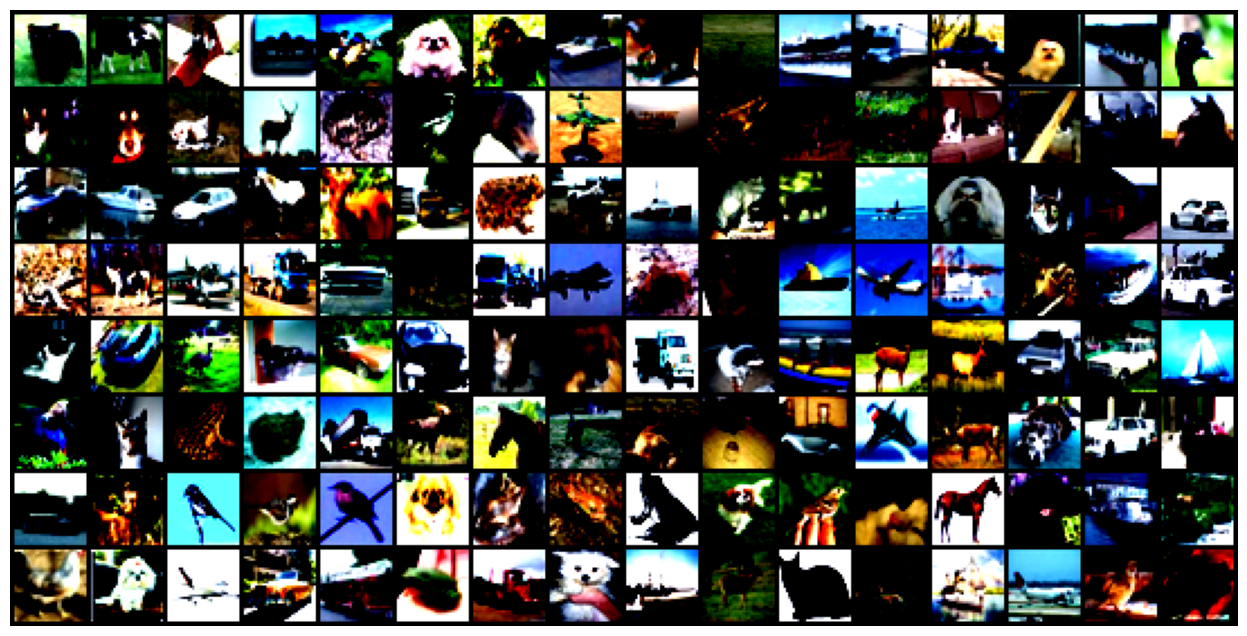

In [ ]:
# Show sample images
for images,_ in trainloader:
    print('images shape:' , images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

sample_image = iter(trainloader)
samples, labels = next(sample_image)
print(samples.shape)
print(labels)

In [ ]:
# Save function
def save_checkpoint(model, optimizer, epoch, training_stats, total_time, filename="/content/drive/MyDrive/Assignment 2_DLF/checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_stats': training_stats,  # Add training stats here
        'total_time': total_time  # Add total time here
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch}")

def plot_learning_curve(training_stats):
    """Plots the training and validation results.

    Args:
        training_stats: A list of dictionaries containing training statistics.
                       Each dictionary should have the following keys:
                       'Epoch', 'Train_Loss', 'Train_Acc', 'Val_Acc', 'Val_Loss'.
    """
    if training_stats is None or len(training_stats) == 0:
        print("Training statistics not available. Train the model first.")
        return

    # Extract the statistics from the dictionary
    epochs = [stat['Epoch'] for stat in training_stats]
    train_losses = [stat['Train_Loss'] for stat in training_stats]
    val_losses = [stat['Val_Loss'] for stat in training_stats]
    train_accs = [stat['Train_Acc'] for stat in training_stats]
    val_accs = [stat['Val_Acc'] for stat in training_stats]

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot Training/Validation Loss
    axs[0].set_title("Training/Validation Loss over Epochs")
    axs[0].plot(epochs, train_losses, label="Training Loss", color="blue")
    axs[0].plot(epochs, val_losses, label="Validation Loss", color="orange")
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot Training/Validation Accuracy
    axs[1].set_title("Training/Validation Accuracy over Epochs")
    axs[1].plot(epochs, train_accs, label="Training Accuracy", color="blue")
    axs[1].plot(epochs, val_accs, label="Validation Accuracy", color="orange")
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

class ModelTrainer(nn.Module):

    def train_network(self, trainloader, valloader, num_epochs, criterion, optimizer, training_stats = [], start_epoch=0, total_time=0):
        start_time = time.time()
        #training_stats = []
        self.epochs = num_epochs
        self.stats_list = []
        early_stop = EarlyStopping(patience=2, min_delta=1)

        for epoch in range(start_epoch, num_epochs):
            self.train()
            batch_loss, batch_acc = [], []
            for i, batch_data in enumerate(trainloader, 0):
                inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
                optimizer.zero_grad()
                predictions = self(inputs)
                loss = criterion(predictions, labels)
                loss.backward()
                optimizer.step()

            train_acc, train_loss = self.compute_acc_and_loss(trainloader, criterion)
            val_acc, val_loss = self.compute_acc_and_loss(valloader, criterion, mode="val")

            if early_stop.should_stop(val_loss):
                break

            epoch_stat = {"Epoch": epoch + 1, "Train_Loss": train_loss, "Train_Acc": train_acc, "Val_Acc": val_acc, "Val_Loss": val_loss}
            print(epoch_stat)
            training_stats.append(epoch_stat)

            if epoch % 2 == 0 and epoch>0:
              elapsed_time = total_time + (time.time() - start_time)
              save_checkpoint(self, optimizer, epoch, training_stats, elapsed_time)

        self.stats_list = training_stats
        print('Training Completed')
        print(f"Total Time: {round((time.time() - start_time) / 60, 2)} minutes")

    def compute_acc_and_loss(self, loader, criterion, mode='train'):
        self.eval()
        loss_values, accuracy_list = [], []
        total_samples, correct_predictions = 0, 0
        with torch.no_grad():
            for i, data in enumerate(loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = self(inputs)
                total_samples += labels.size(0)
                _, predicted_labels = torch.max(outputs.data, 1)
                correct_predictions += (predicted_labels == labels).sum().item()
                loss = criterion(outputs, labels)
                loss_values.append(loss.item())
        mean_loss = np.mean(loss_values)
        accuracy = (100 * correct_predictions / total_samples)
        return accuracy, mean_loss

    def predict(self, testloader):
        self.eval()
        predictions_list = []
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                predictions_list.extend(predicted.cpu().numpy())
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Accuracy of the network on the test data: {accuracy:.2f}%')
        return predictions_list, accuracy

    def class_accuracy(self, loader, classes):  # Add loader and classes as arguments
        class_correct = list(0. for i in range(len(classes)))
        class_total = list(0. for i in range(len(classes)))
        with torch.no_grad():
            for data in loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == labels).squeeze()
                for i in range(len(labels)):  # len(labels) gives the batch size
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(len(classes)):
            print('Accuracy of %5s : %2d %%' % (
                classes[i], 100 * class_correct[i] / class_total[i]))

    def plot_training_results(self):
        train_accuracies = [x['Train_Acc'] for x in self.stats_list]
        val_accuracies = [x['Val_Acc'] for x in self.stats_list]
        train_losses = [x['Train_Loss'] for x in self.stats_list]
        val_losses = [x['Val_Loss'] for x in self.stats_list]

        # Create subplots with 1 row and 2 columns
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        # Plot Training/Validation Loss
        axs[0].set_title("Training/Validation Loss over Epochs")
        axs[0].plot(np.arange(self.epochs), train_losses, label="Training Loss", color="blue")
        axs[0].plot(np.arange(self.epochs), val_losses, label="Validation Loss", color="orange")
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].legend()

        # Plot Training/Validation Accuracy
        axs[1].set_title("Training/Validation Accuracy over Epochs")
        axs[1].plot(np.arange(self.epochs), train_accuracies, label="Training Accuracy", color="green")
        axs[1].plot(np.arange(self.epochs), val_accuracies, label="Validation Accuracy", color="red")
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy (%)')
        axs[1].legend()

        # Adjust layout for better spacing
        plt.tight_layout()
        plt.show()

class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_val_loss = np.inf

    def should_stop(self, validation_loss):
        if validation_loss < self.min_val_loss:
            self.min_val_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_val_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

**RESIZE IMAGE TO 224,224**

In [ ]:
# Reshape image to 224x224
transform_train_reshape = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet-18 input size
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.ToTensor(),
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test_reshape = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Apply these transformations to your datasets
train_dataset_reshape = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/Assignment 2_DLF/train_data/', train=True, download=False, transform=transform_train_reshape)
test_dataset_reshape = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/Assignment 2_DLF/test_data/', train=False, download=False, transform=transform_test_reshape)

# Split train val set
val_size = int(0.2 * len(train_dataset_reshape))
val_size_reshape = int(0.2 * len(train_dataset_reshape))
train_size_reshape = len(train_dataset_reshape) - val_size
train_dataset_reshape, val_dataset_reshape = random_split(train_dataset_reshape, [train_size_reshape, val_size_reshape])

# Create DataLoader for each set
batch_size = 128
trainloader_reshape = DataLoader(train_dataset_reshape, batch_size=batch_size, shuffle=True, num_workers=2)
valloader_reshape = DataLoader(val_dataset_reshape, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader_reshape = DataLoader(test_dataset_reshape, batch_size=batch_size, shuffle=False, num_workers=2)

print('Train data size:', len(train_dataset_reshape))
print('Validation data size:', len(val_dataset_reshape))
print('Test data size:', len(test_dataset_reshape))


Train data size: 40000
Validation data size: 10000
Test data size: 10000


**MODEL RESNET-18**

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer of the block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer of the block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet18Trainer(ModelTrainer):
    def __init__(self, num_classes):
        super(ResNet18Trainer, self).__init__()
        self.in_channels = 64

        # Initial convolution and max pooling layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet-18 consists of 4 layers with specific block and number of blocks in each layer
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        # Fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

        self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Pass through each layer
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [ ]:
model_resnet18 = ResNet18Trainer(num_classes=10).to(device)
summary(model_resnet18, input_size=(3, 224, 224))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.parameters(), lr=0.001)
num_epochs = 1

model_resnet18.train_network(trainloader_reshape, valloader_reshape, num_epochs, criterion, optimizer)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]          36,864
       BatchNorm2d-5           [-1, 64, 56, 56]             128
            Conv2d-6           [-1, 64, 56, 56]          36,864
       BatchNorm2d-7           [-1, 64, 56, 56]             128
        BasicBlock-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,864
      BatchNorm2d-10           [-1, 64, 56, 56]             128
           Conv2d-11           [-1, 64, 56, 56]          36,864
      BatchNorm2d-12           [-1, 64, 56, 56]             128
       BasicBlock-13           [-1, 64, 56, 56]               0
           Conv2d-14          [-1, 128,

In [ ]:
model_resnet18 = ResNet18Trainer(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.parameters(), lr=0.001)
num_epochs = 18

checkpoint = torch.load('/content/drive/MyDrive/Assignment 2_DLF/checkpoint.pth')
model_resnet18.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
training_stats = checkpoint['training_stats']
start_epoch = checkpoint['epoch'] + 1
elapsed_time = checkpoint['total_time']
print(start_epoch)
print(elapsed_time)

model_resnet18.train_network(trainloader_reshape, valloader_reshape, num_epochs, criterion, optimizer, training_stats, start_epoch, elapsed_time)

<ipython-input-19-4f5214c9ab1c>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/Assignment 2_DLF/checkpoint.pth')


17
1771.3244097232819
{'Epoch': 18, 'Train_Loss': 0.08304392234585918, 'Train_Acc': 97.1625, 'Val_Acc': 95.98, 'Val_Loss': 0.12124846580945238}
Training Completed
Total Time: 3.71 minutes


Accuracy of plane : 99 %
Accuracy of   car : 99 %
Accuracy of  bird : 96 %
Accuracy of   cat : 86 %
Accuracy of  deer : 97 %
Accuracy of   dog : 97 %
Accuracy of  frog : 94 %
Accuracy of horse : 97 %
Accuracy of  ship : 96 %
Accuracy of truck : 97 %
Validation Accuracy: 96.11%


<ipython-input-20-ac4b1c9e4a22>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/Assignment 2_DLF/checkpoint.pth')


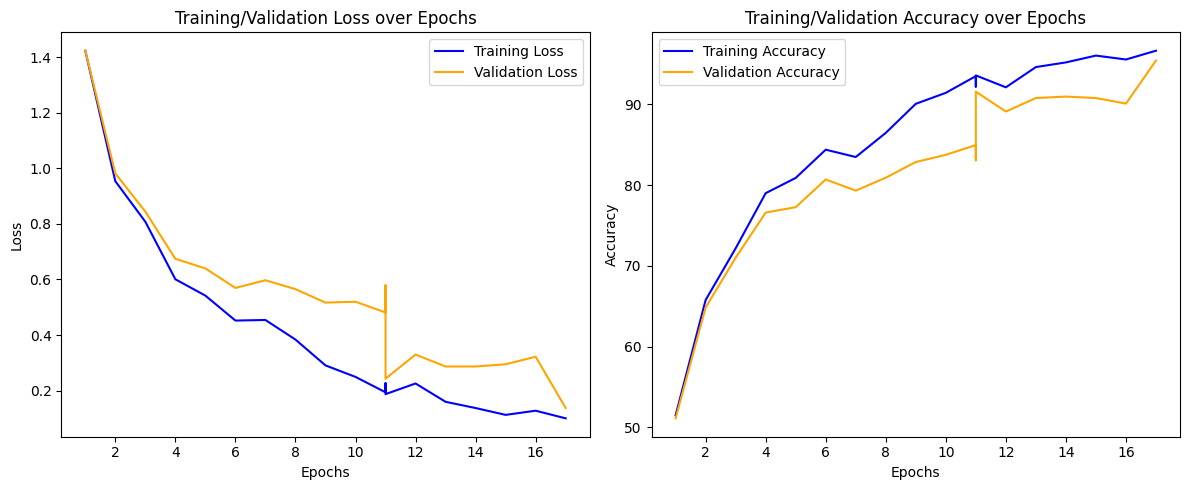

In [ ]:
model_resnet18.class_accuracy(valloader_reshape, model_resnet18.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_resnet18.compute_acc_and_loss(valloader_reshape, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")

# Plot training result from the latest checkpoint
checkpoint = torch.load('/content/drive/MyDrive/Assignment 2_DLF/checkpoint.pth')
training_stats = checkpoint['training_stats']
plot_learning_curve(training_stats)

In [ ]:
# train model resnet18 with SGD optim
model_resnet18_2 = ResNet18Trainer(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet18_2.parameters(), lr=0.001, momentum=0.9)
num_epochs = 5

model_resnet18_2.train_network(trainloader_reshape, valloader_reshape, num_epochs, criterion, optimizer)

{'Epoch': 1, 'Train_Loss': 1.3817085892247696, 'Train_Acc': 49.0375, 'Val_Acc': 48.34, 'Val_Loss': 1.4128742202927795}
{'Epoch': 2, 'Train_Loss': 1.119326148360682, 'Train_Acc': 60.1225, 'Val_Acc': 58.97, 'Val_Loss': 1.1503843114345889}
{'Epoch': 3, 'Train_Loss': 1.1572505540360276, 'Train_Acc': 60.245, 'Val_Acc': 58.7, 'Val_Loss': 1.2173948740657372}
Checkpoint saved at epoch 2
{'Epoch': 4, 'Train_Loss': 0.8544817513551194, 'Train_Acc': 69.675, 'Val_Acc': 66.79, 'Val_Loss': 0.9285846714732013}
{'Epoch': 5, 'Train_Loss': 0.713646184522123, 'Train_Acc': 74.5225, 'Val_Acc': 70.44, 'Val_Loss': 0.8216042239454728}
Checkpoint saved at epoch 4
Training Completed
Total Time: 18.53 minutes


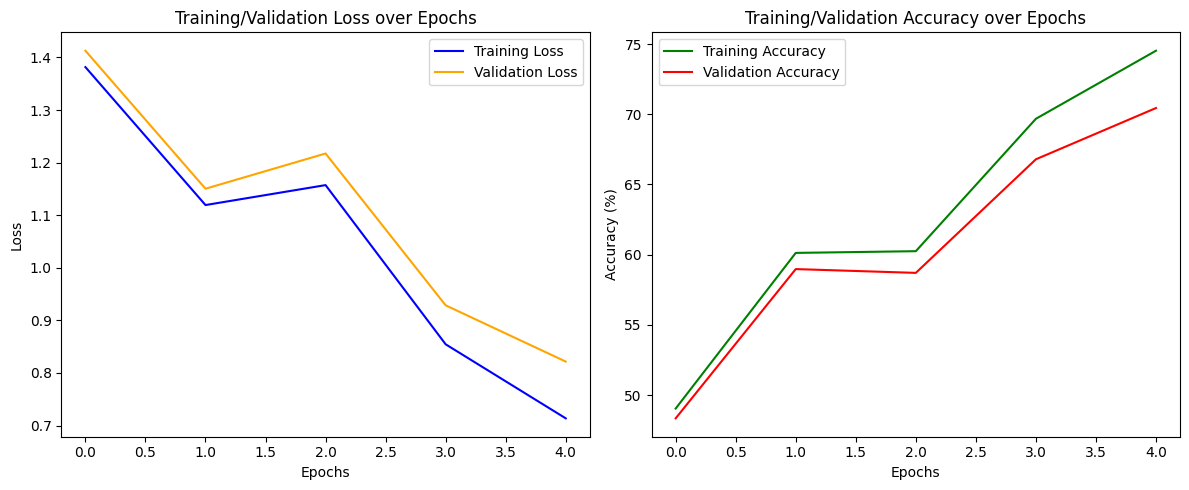

In [ ]:
model_resnet18_2.plot_training_results()

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_rate=0.5):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        out = self.dropout(out)  # Apply dropout after the residual connection

        return out

class ResNet18Trainer(ModelTrainer):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(ResNet18Trainer, self).__init__()
        self.in_channels = 64

        # Initial convolution and max pooling layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet-18 layers
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2, dropout_rate=dropout_rate)

        # Fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

        # Final dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    def _make_layer(self, block, out_channels, blocks, stride, dropout_rate):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_rate))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, dropout_rate=dropout_rate))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Pass through each layer
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Apply final dropout before the output layer
        return self.fc(x)


In [ ]:
model_resnet18_3 = ResNet18Trainer(num_classes=10).to(device)
summary(model_resnet18_3, input_size=(3, 224, 224))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18_3.parameters(), lr=0.001)
num_epochs = 10

model_resnet18_3.train_network(trainloader_reshape, valloader_reshape, num_epochs, criterion, optimizer)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]          36,864
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
          Dropout-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
model_resnet18_3 = ResNet18Trainer(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18_3.parameters(), lr=0.001)
num_epochs = 18

checkpoint = torch.load('/content/drive/MyDrive/Assignment 2_DLF/checkpoint.pth')
model_resnet18_3.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
training_stats = checkpoint['training_stats']
start_epoch = checkpoint['epoch'] + 1
elapsed_time = checkpoint['total_time']
print(start_epoch)
print(elapsed_time)

model_resnet18_3.train_network(trainloader_reshape, valloader_reshape, num_epochs, criterion, optimizer, training_stats, start_epoch, elapsed_time)

<ipython-input-43-5c05ed310691>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/Assignment 2_DLF/checkpoint.pth')


9
2012.3517618179321
{'Epoch': 10, 'Train_Loss': 0.4760261842617973, 'Train_Acc': 83.405, 'Val_Acc': 80.71, 'Val_Loss': 0.5538773527251014}
{'Epoch': 11, 'Train_Loss': 0.4367028045387695, 'Train_Acc': 84.555, 'Val_Acc': 82.08, 'Val_Loss': 0.5238760781439045}
Checkpoint saved at epoch 10
{'Epoch': 12, 'Train_Loss': 0.4268725137836255, 'Train_Acc': 85.0075, 'Val_Acc': 81.83, 'Val_Loss': 0.5327656552006926}
{'Epoch': 13, 'Train_Loss': 0.34967606093365544, 'Train_Acc': 87.83, 'Val_Acc': 84.58, 'Val_Loss': 0.45282867814921124}
Checkpoint saved at epoch 12
{'Epoch': 14, 'Train_Loss': 0.34901476163452805, 'Train_Acc': 87.8775, 'Val_Acc': 84.17, 'Val_Loss': 0.4669519270522685}
{'Epoch': 15, 'Train_Loss': 0.36139487729857145, 'Train_Acc': 87.43, 'Val_Acc': 83.24, 'Val_Loss': 0.4899751159209239}
Checkpoint saved at epoch 14
{'Epoch': 16, 'Train_Loss': 0.2908149091199564, 'Train_Acc': 89.9175, 'Val_Acc': 86.08, 'Val_Loss': 0.4192114417688756}
{'Epoch': 17, 'Train_Loss': 0.30094622842039165, 'Trai

In [ ]:
model_resnet18_3.class_accuracy(valloader_reshape, model_resnet18_3.classes)
val_acc, val_loss = model_resnet18_3.compute_acc_and_loss(valloader_reshape, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")

Accuracy of plane : 78 %
Accuracy of   car : 92 %
Accuracy of  bird : 86 %
Accuracy of   cat : 70 %
Accuracy of  deer : 79 %
Accuracy of   dog : 80 %
Accuracy of  frog : 89 %
Accuracy of horse : 94 %
Accuracy of  ship : 94 %
Accuracy of truck : 95 %
Validation Accuracy: 86.28%


<ipython-input-48-8686d32b5054>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/Assignment 2_DLF/checkpoint.pth')


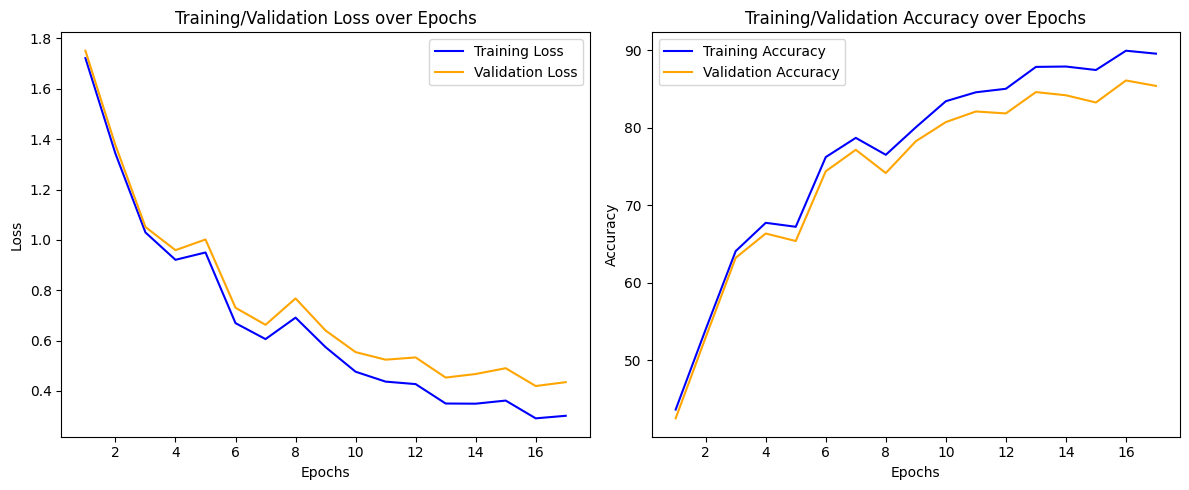

In [ ]:
# Plot training result from the latest checkpoint
checkpoint = torch.load('/content/drive/MyDrive/Assignment 2_DLF/checkpoint.pth')
training_stats = checkpoint['training_stats']
plot_learning_curve(training_stats[5:])